In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipyleaflet import Map, CircleMarker, Heatmap

In [2]:
#einlesen u. bereinigen v. zeitreihe
#importing and cleaning data
cal = pd.read_csv('../data/calendar.csv')
cal[['available']] = cal[['available']].replace('t',True)
cal[['available']] = cal[['available']].replace('f',False)

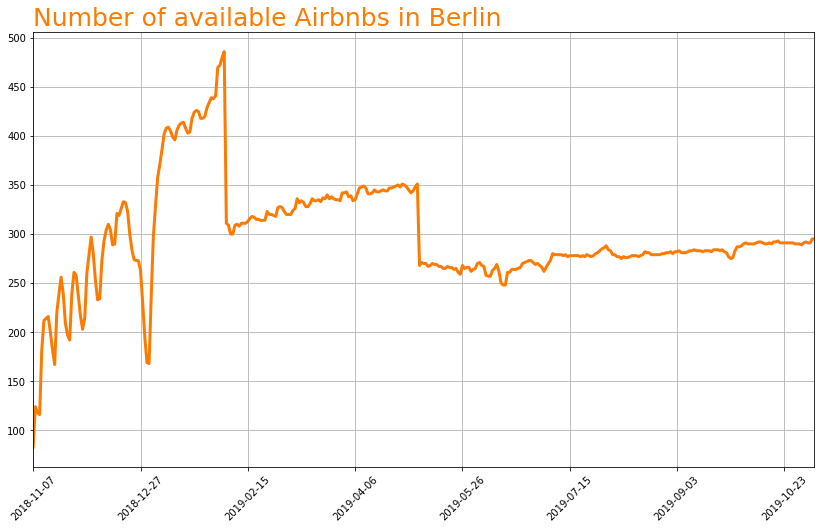

In [3]:
#listings vom selben tag aufsummieren und plotten
#sum listings of the same day and plot
fig,ax = plt.subplots(figsize=(14,8))
date_av = cal.groupby('date').sum()[['available']]
date_av.plot(ax = ax, color='#fc7b03', linewidth=3)      #plot() funktion aus pandas (geplottet auf matplotlib fig)
ax.get_legend().remove()
plt.xticks(rotation=45)
plt.title('Number of available Airbnbs in Berlin', fontsize= 25,color='#fc7b03', loc='left')
ax.grid(True)
plt.xlabel('')
plt.show()

In [4]:
#einlesen u. bereinigung v. listings
#importing and cleaning 'listings.csv'
listings = pd.read_csv('../data/listings.csv')
listings['cleaning_fee'] = listings['cleaning_fee'].str.replace('$','')
listings['cleaning_fee'] = listings['cleaning_fee'].str.replace(',','')
listings['price'] = listings['price'].str.replace('$','')
listings['price'] = listings['price'].str.replace(',','')
listings['price'] = listings['price'].astype(float)
listings['cleaning_fee'] = listings['cleaning_fee'].astype(float)
#addieren des preises und der cleaing fee für später
listings['cleaning_fee'].fillna(0, inplace=True)
listings['price_and_clean'] = listings['price'] + listings['cleaning_fee']

In [5]:
#liste an stadtteilen
#list of districts
districtnames = listings['neighbourhood_group_cleansed'].unique()
districtnames = list(districtnames) # make districts a list (before nparray)
districtcount = len(districtnames)

In [6]:
#erstellt listen mit mittleren preisen, standardabw. und anzahl and listings d. vers. stadtteile
#create lists of mean prices, stddev and num of listings per district
districtprices = [None] * districtcount
districtdeviation = [None] * districtcount
districtlistings = [None] * districtcount
for i in districtnames:
    d = listings[listings['neighbourhood_group_cleansed'] == districtnames[districtnames.index(i)]]
    districtprices[districtnames.index(i)] = d['price'].mean()
    districtdeviation[districtnames.index(i)] = d['price'].std()
    districtlistings[districtnames.index(i)] = d.shape[0]
# means, stddevs und anzahl als df gespeichert
districts = pd.DataFrame(list(zip(districtprices, districtdeviation, districtlistings)), index = districtnames,
            columns =['Mean Prices', 'Standarddeviation', 'Number of Listings'])
display(districts)

,Mean Prices,Standarddeviation,Number of Listings
Neukölln,46.969436,33.427404,2094
Treptow - Köpenick,51.413978,36.393931,372
Pankow,69.911778,159.932255,2165
Friedrichshain-Kreuzberg,62.231076,161.839758,3263
Mitte,69.929888,108.078736,2767
Tempelhof - Schöneberg,104.808602,518.173057,930
Lichtenberg,63.652605,251.300406,403
Charlottenburg-Wilm.,133.708768,665.424698,958
Steglitz - Zehlendorf,54.854406,47.082353,261
Reinickendorf,51.013423,75.526976,149


In [7]:
#string mit namen des lowest mean districts
#find lowest mean district
lowestmeandistrict = districtnames[districtprices.index(min(districtprices))]
#listings im lowest mean district
#get listings in lowest mean district
lowestmeanlistings = listings[listings['neighbourhood_group_cleansed'] == lowestmeandistrict]

#string mit namen des highest mean districts
#get highest mean district
highestmeandistrict = districtnames[districtprices.index(max(districtprices))]
#listings im highest mean district
#get listings in highest mean district
highestmeanlistings = listings[listings['neighbourhood_group_cleansed'] == highestmeandistrict]

In [8]:
#### boxplots der teursten und günstisgsten nebeneinander
#boxplots, least and most expensive districts next to each other
#fig , ax = plt.subplots(1,2, sharex = True, sharey=True)
#ax[0].boxplot(lowestmeanlistings['price'])
#ax[1].boxplot(highestmeanlistings['price'])
#plt.ylim(0,150)
#plt.show()

In [9]:
#funktion, die boxplots erstellt und dictionaries als input nimmt
#funktion which creates boxplots and takes dicts as input
def dictbp(inputdict, title = 'Boxplot', ymax = 150):
    fig, ax = plt.subplots(figsize = (4,(ymax/150)*6))
    ax.boxplot(inputdict.values())
    ax.set_xticklabels(inputdict.keys())
    ax.set_title(title)
    plt.ylim(0, ymax)
    plt.show()

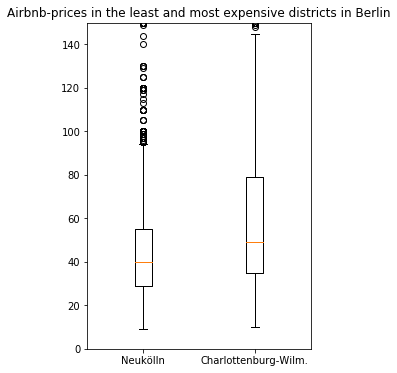

In [10]:
#boxplots der teursten und günstisgsten stadtteile 
#als dict in einem graph
#least and most expensive district boxplots in one graph
dict0 =  {lowestmeandistrict: lowestmeanlistings['price'], highestmeandistrict: highestmeanlistings['price']}
dictbp(dict0, 'Airbnb-prices in the least and most expensive districts in Berlin')

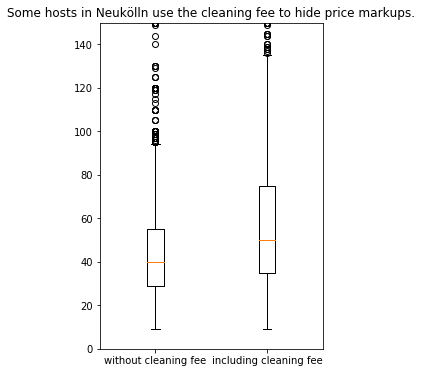

In [11]:
#price cleaning fee comparison lowestmeandistrict
dict1 = {'without cleaning fee': lowestmeanlistings['price'], 
         'including cleaning fee':lowestmeanlistings['price_and_clean']}
dictbp(dict1, 'Some hosts in Neukölln use the cleaning fee to hide price markups.')

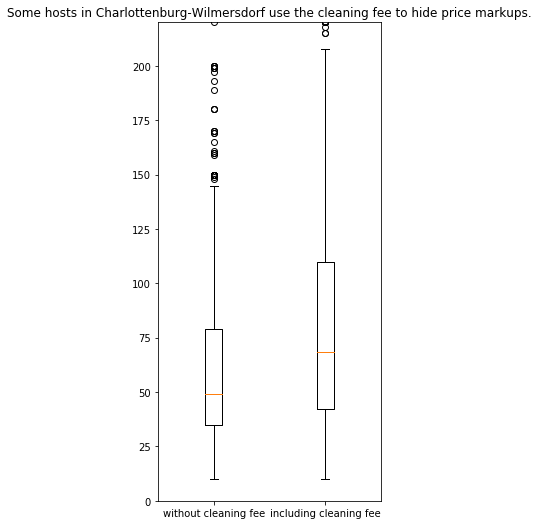

In [12]:
#price cleaning fee comparison highestmeandistrict
dict2 = {'without cleaning fee': highestmeanlistings['price'], 
         'including cleaning fee':highestmeanlistings['price_and_clean']}
dictbp(dict2, 'Some hosts in Charlottenburg-Wilmersdorf use the cleaning fee to hide price markups.', 220)

In [13]:
#reviews df einlesen, zählen und die top200 airbnb's extrahieren
#import reviews df, filter top 200 most reviewed airbnbs
reviews = pd.read_csv('../data/reviews.csv')
review_count = pd.DataFrame(reviews['listing_id'].value_counts())
review_count.reset_index(level=0, inplace=True)
review_count.columns = ['id', 'n_reviews']
listings_merged = pd.merge(listings, review_count, on='id')
listings_merged.sort_values('n_reviews', axis=0, ascending=False, inplace=True, na_position='last')
top200 = listings_merged.iloc[:200,:]
top200counted_raw = top200.groupby(['neighbourhood_group_cleansed']).count()
top200counted = pd.DataFrame(top200counted_raw.iloc[:,:1]).sort_values('Unnamed: 0')

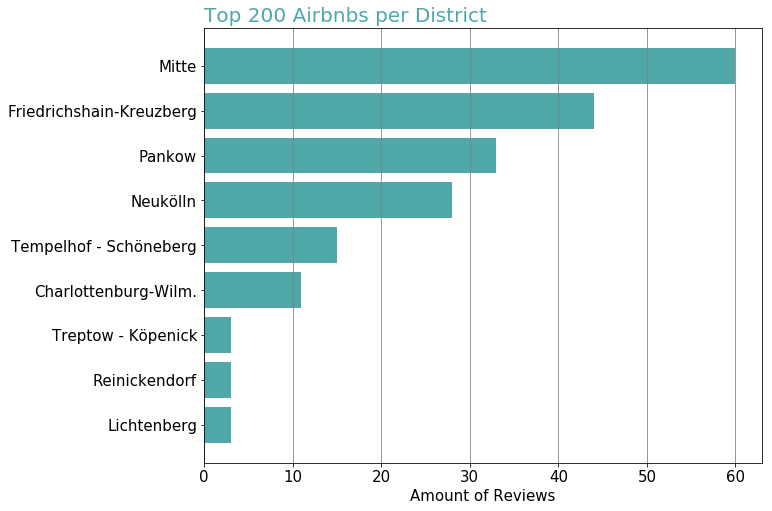

In [14]:
#top 200 plotten
#plot top200
plt.figure(figsize=(10,8))
plt.barh(top200counted.index, top200counted['Unnamed: 0'], align = 'center',color='#4fa7a8')
plt.title('Top 200 Airbnbs per District', fontsize= 20,color='#4fa7a8', loc='left')
plt.yticks(fontsize= 15)
plt.xticks(fontsize= 15)
plt.xlabel('Amount of Reviews', fontsize = 15)
plt.grid(b = True, axis = 'x',color='grey')
plt.show()

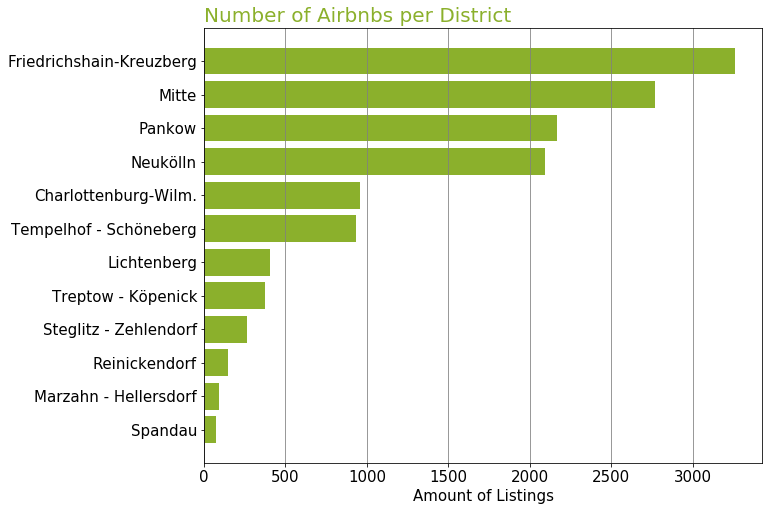

In [15]:
#anzahl an airbnblistings pro stadtteil visualisiert
districts.sort_values('Number of Listings', inplace = True)
plt.figure(figsize=(10,8))
plt.barh(districts.index, districts['Number of Listings'], align = 'center',color='#8bb02c')
plt.title('Number of Airbnbs per District', fontsize= 20,color='#8bb02c', loc='left')
plt.yticks(fontsize= 15)
plt.xticks(fontsize= 15)
plt.xlabel('Amount of Listings', fontsize = 15)
plt.grid(b = True, axis = 'x',color='grey')
plt.show()

In [16]:
#dataframe wird um spalte erweitert, die die zum stadtteil gehörenden farben entält
#add corresponding color for every district
colordict = {
            districtnames[0]:'LightCoral',
            districtnames[1]:'Chocolate',
            districtnames[2]:'LimeGreen',
            districtnames[3]:'FireBrick',
            districtnames[4]:'Aqua',
            districtnames[5]:'DarkOrange',
            districtnames[6]:'BlueViolet',
            districtnames[7]:'Gold',
            districtnames[8]:'Lavender',
            districtnames[9]:'DarkKhaki',
            districtnames[10]:'OliveDrab',
            districtnames[11]:'Teal',
            }
listings_merged['color'] = listings_merged['neighbourhood_group_cleansed'].map(colordict)

In [17]:
#visualizing the top 1000 listings on a map, every dot is a listings, color of dot shows district of listing
#used ipyleaflet, may not work on github
numoflistings = 1000
m = Map(center=(52.5, 13.4), zoom=11)
for i, r in listings_merged.iloc[:numoflistings,:].iterrows():
    m.add_layer(CircleMarker(location=(r['latitude'],r['longitude']), draggable=False, radius= 1, 
    color = r['color']))
display(m)

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …